# Nearest Neighbours - Synthetic Dataset (SR0)

## Importing packages and loading necessary datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipdw
from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold
from photutils.utils import ShepardIDWInterpolator
import time
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [2]:
import os

# Get the current working directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

# Change to the parent directory
os.chdir(parent_dir)

# Print the new current working directory to confirm
print("Changed to:", os.getcwd())

Changed to: C:\Users\chloe\OneDrive\AY2024 FYP\FYP-Code\FYP-Spatial-Analytics


# 200 points calibration

In [3]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR0/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR0_input_randomfield_cal200.csv')
val_df = pd.read_csv(f'{file_path}val_SR0_input_randomfield_cal200.csv')
test_df = pd.read_csv(f'{file_path}test_SR0_input_randomfield_cal200.csv')

In [4]:
# Initialize an empty dictionary for storing scores
cv_score_list_200_k = {}
neighbors_range = np.arange(1, 20)

start_time = time.time()

# For each hyperparameter value
for k in neighbors_range:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Instantiate and fit model with calibration data
    nn_model = KNeighborsRegressor(n_neighbors=k)
    nn_model.fit(combined_array_train,cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = nn_model.predict(combined_array_validation)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_200_k[k] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_200_k))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_200_k.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in K = {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in K = {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Validation Score MAE,0.428885,0.414841,0.420741,0.443040,0.460203,0.478044,0.497203,0.507976,0.516041,0.525008,0.533762,0.543777,0.553929,0.560183,0.567295,0.576556,0.585024,0.590882,0.600222
Validation Score RMSE,0.582797,0.548239,0.553669,0.575598,0.596348,0.617818,0.639168,0.653718,0.667089,0.680316,0.691903,0.707024,0.719532,0.728221,0.735460,0.744828,0.753455,0.760508,0.769807
Validation Score MAPE,6.361820,8.010163,9.244055,6.584115,6.373717,5.809116,5.744370,5.810757,6.693341,7.282887,7.149352,7.264933,7.496651,7.335431,7.453374,7.007658,7.032264,7.036367,7.186618
Validation Score R Squared,0.650370,0.690605,0.684446,0.658955,0.633922,0.607088,0.579464,0.560099,0.541920,0.523575,0.507208,0.485433,0.467065,0.454115,0.443209,0.428934,0.415630,0.404637,0.389990


The smallest Validation Score MAE is 0.41484058153303305, found in K = 2.
The smallest Validation Score RMSE is 0.5482388321975985, found in K = 2.
The smallest Validation Score MAPE is 5.744370401453779, found in K = 7.
The largest Validation Score R Squared is 0.6906048047273459, found in K = 2.
Validation Computation Time: 0.10 seconds


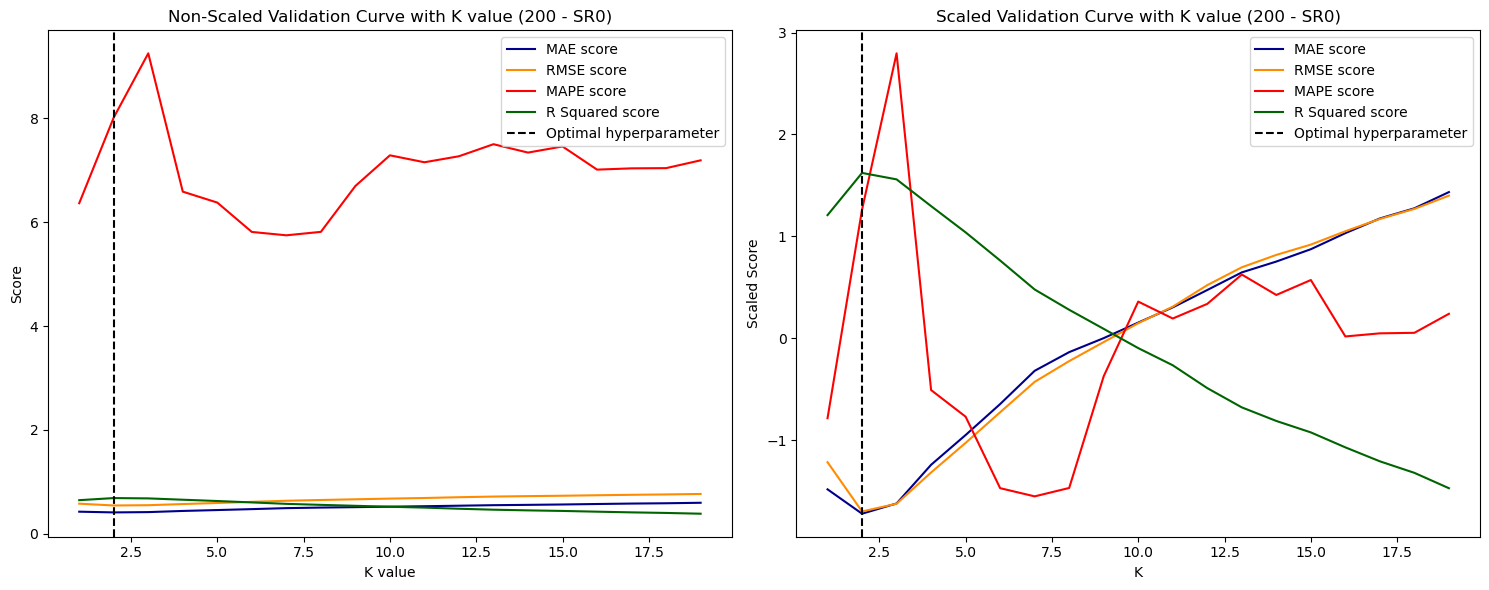

In [5]:
k = 2
df = pd.DataFrame(cv_score_list_200_k).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(neighbors_range, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(neighbors_range, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(neighbors_range, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(neighbors_range, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('K value')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with K value (200 - SR0)")

# Plot normalized data on the second subplot
ax[1].plot(neighbors_range, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('K')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with K value (200 - SR0)")

plt.tight_layout()
plt.show()

# 400 points calibration

In [6]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR0/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR0_input_randomfield_cal400.csv')
val_df = pd.read_csv(f'{file_path}val_SR0_input_randomfield_cal400.csv')
test_df = pd.read_csv(f'{file_path}test_SR0_input_randomfield_cal400.csv')

In [7]:
# Initialize an empty dictionary for storing scores
cv_score_list_400_k = {}
neighbors_range = np.arange(1, 20)

start_time = time.time()

# For each hyperparameter value
for k in neighbors_range:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Instantiate and fit model with calibration data
    nn_model = KNeighborsRegressor(n_neighbors=k)
    nn_model.fit(combined_array_train,cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = nn_model.predict(combined_array_validation)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_400_k[k] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_400_k))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_400_k.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in K = {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in K = {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Validation Score MAE,0.317476,0.293643,0.308402,0.326826,0.346558,0.363532,0.380305,0.392701,0.404299,0.416768,0.425620,0.439630,0.451591,0.460841,0.470400,0.478295,0.483978,0.490003,0.495105
Validation Score RMSE,0.438789,0.404327,0.418929,0.440279,0.462428,0.481676,0.499885,0.513850,0.526015,0.539153,0.553409,0.572048,0.588548,0.601615,0.613667,0.623165,0.632049,0.640793,0.649141
Validation Score MAPE,5.487075,2.759875,5.079579,4.081615,4.536813,6.356211,6.481709,6.969954,6.607692,6.867092,7.548503,7.340949,7.303350,7.156061,6.897392,7.356194,7.487495,7.657826,7.604561
Validation Score R Squared,0.801808,0.831717,0.819343,0.800460,0.779878,0.761173,0.742774,0.728201,0.715180,0.700775,0.684742,0.663148,0.643436,0.627427,0.612350,0.600257,0.588779,0.577322,0.566237


The smallest Validation Score MAE is 0.29364323756202193, found in K = 2.
The smallest Validation Score RMSE is 0.40432685247667505, found in K = 2.
The smallest Validation Score MAPE is 2.7598750999301855, found in K = 2.
The largest Validation Score R Squared is 0.8317174254559799, found in K = 2.
Validation Computation Time: 0.12 seconds


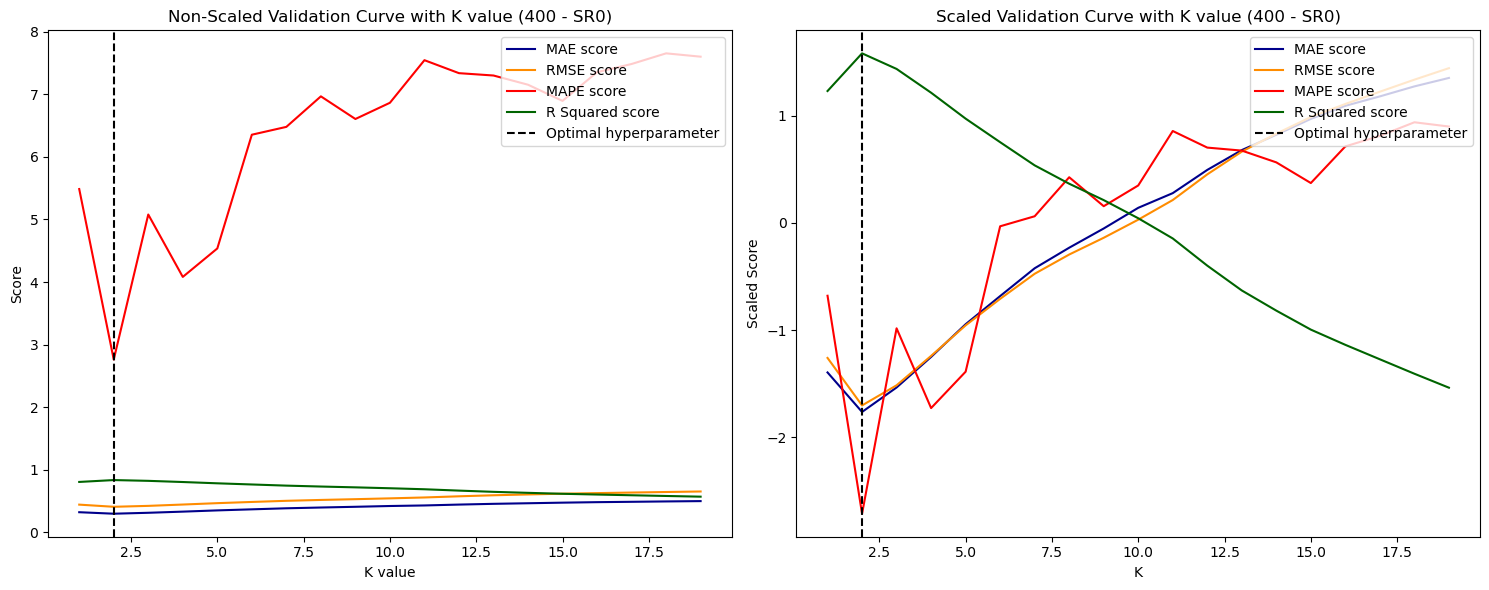

In [8]:
k = 2
df = pd.DataFrame(cv_score_list_400_k).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(neighbors_range, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(neighbors_range, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(neighbors_range, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(neighbors_range, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('K value')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with K value (400 - SR0)")

# Plot normalized data on the second subplot
ax[1].plot(neighbors_range, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('K')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with K value (400 - SR0)")

plt.tight_layout()
plt.show()

# 600 points calibration

In [9]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR0/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR0_input_randomfield_cal600.csv')
val_df = pd.read_csv(f'{file_path}val_SR0_input_randomfield_cal600.csv')
test_df = pd.read_csv(f'{file_path}test_SR0_input_randomfield_cal600.csv')

In [10]:
# Initialize an empty dictionary for storing scores
cv_score_list_600_k = {}
neighbors_range = np.arange(1, 20)

start_time = time.time()

# For each hyperparameter value
for k in neighbors_range:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Instantiate and fit model with calibration data
    nn_model = KNeighborsRegressor(n_neighbors=k)
    nn_model.fit(combined_array_train,cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = nn_model.predict(combined_array_validation)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_600_k[k] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_600_k))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_600_k.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in K = {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in K = {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Validation Score MAE,0.266263,0.245316,0.257546,0.270821,0.286369,0.300062,0.314157,0.331070,0.345950,0.357785,0.370717,0.382532,0.392359,0.401838,0.410748,0.418612,0.426097,0.437695,0.444695
Validation Score RMSE,0.366857,0.338574,0.350246,0.368622,0.388156,0.402656,0.416720,0.434477,0.451863,0.466409,0.482885,0.496878,0.509436,0.520885,0.531598,0.543260,0.553959,0.567133,0.576188
Validation Score MAPE,5.167892,2.513780,4.175718,5.266996,5.754753,4.701786,5.095960,5.634057,6.737692,6.836660,7.179977,7.292371,7.704425,7.543011,7.647607,7.681014,8.051634,7.932131,8.022889
Validation Score R Squared,0.861462,0.882000,0.873724,0.860126,0.844909,0.833105,0.821244,0.805685,0.789822,0.776073,0.759972,0.745859,0.732851,0.720708,0.709102,0.696199,0.684115,0.668912,0.658254


The smallest Validation Score MAE is 0.24531553452979166, found in K = 2.
The smallest Validation Score RMSE is 0.3385736389583294, found in K = 2.
The smallest Validation Score MAPE is 2.5137803829883114, found in K = 2.
The largest Validation Score R Squared is 0.8820004746829692, found in K = 2.
Validation Computation Time: 0.11 seconds


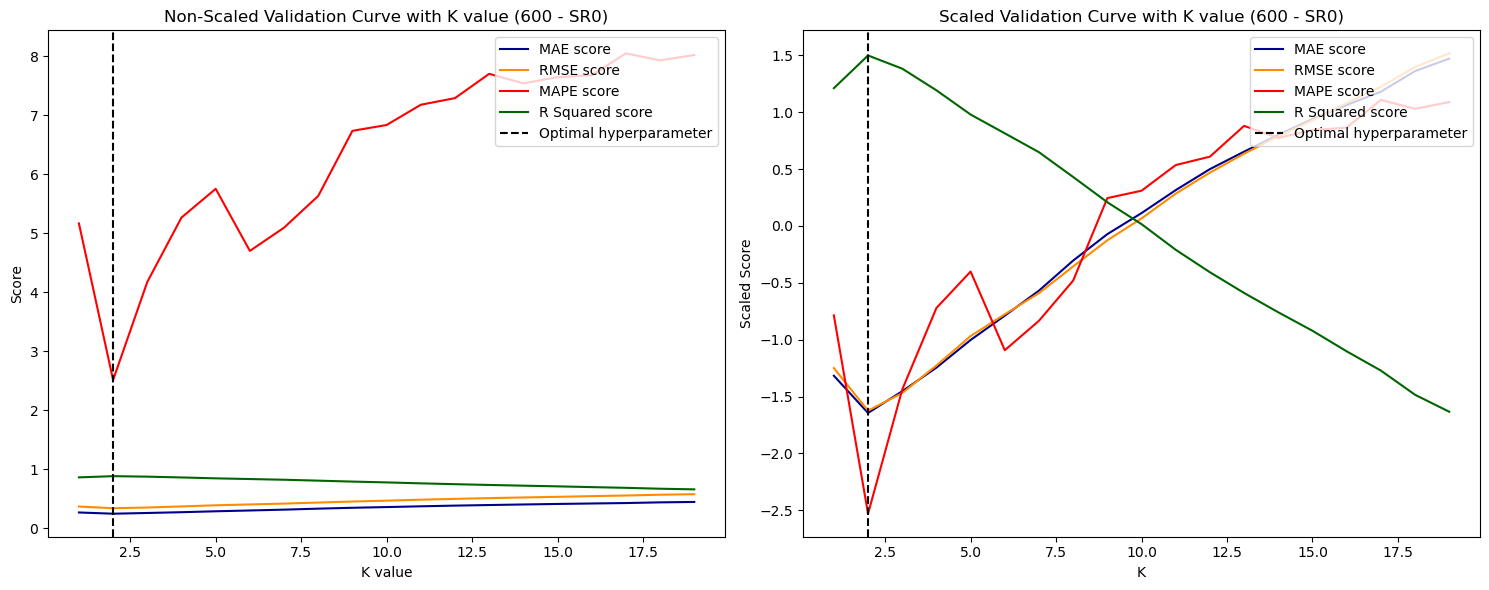

In [11]:
k = 2
df = pd.DataFrame(cv_score_list_600_k).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(neighbors_range, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(neighbors_range, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(neighbors_range, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(neighbors_range, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('K value')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with K value (600 - SR0)")

# Plot normalized data on the second subplot
ax[1].plot(neighbors_range, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('K')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with K value (600 - SR0)")

plt.tight_layout()
plt.show()

# 800 points calibration

In [12]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR0/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR0_input_randomfield_cal800.csv')
val_df = pd.read_csv(f'{file_path}val_SR0_input_randomfield_cal800.csv')
test_df = pd.read_csv(f'{file_path}test_SR0_input_randomfield_cal800.csv')

In [13]:
# Initialize an empty dictionary for storing scores
cv_score_list_800_k = {}
neighbors_range = np.arange(1, 20)

start_time = time.time()

# For each hyperparameter value
for k in neighbors_range:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Instantiate and fit model with calibration data
    nn_model = KNeighborsRegressor(n_neighbors=k)
    nn_model.fit(combined_array_train,cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = nn_model.predict(combined_array_validation)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_800_k[k] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_800_k))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_800_k.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in K = {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in K = {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Validation Score MAE,0.240264,0.215974,0.220500,0.232977,0.245001,0.256419,0.271640,0.284376,0.296393,0.310740,0.321907,0.334783,0.345420,0.356560,0.366695,0.375107,0.381976,0.389124,0.397642
Validation Score RMSE,0.329252,0.297104,0.300526,0.313956,0.329812,0.343760,0.361031,0.375631,0.389170,0.403624,0.416962,0.432958,0.447468,0.461468,0.473598,0.485202,0.493847,0.504644,0.515097
Validation Score MAPE,3.850088,1.929729,2.272030,3.253273,3.922802,4.503634,4.118199,4.325925,5.460127,5.433120,5.885201,6.407434,6.386893,6.798860,6.896996,7.014004,6.962108,6.929884,7.269785
Validation Score R Squared,0.888409,0.909136,0.907031,0.898536,0.888028,0.878358,0.865828,0.854756,0.844098,0.832302,0.821036,0.807041,0.793890,0.780792,0.769116,0.757663,0.748951,0.737854,0.726881


The smallest Validation Score MAE is 0.21597357856888158, found in K = 2.
The smallest Validation Score RMSE is 0.2971037207058843, found in K = 2.
The smallest Validation Score MAPE is 1.9297294984678623, found in K = 2.
The largest Validation Score R Squared is 0.9091363541010385, found in K = 2.
Validation Computation Time: 0.13 seconds


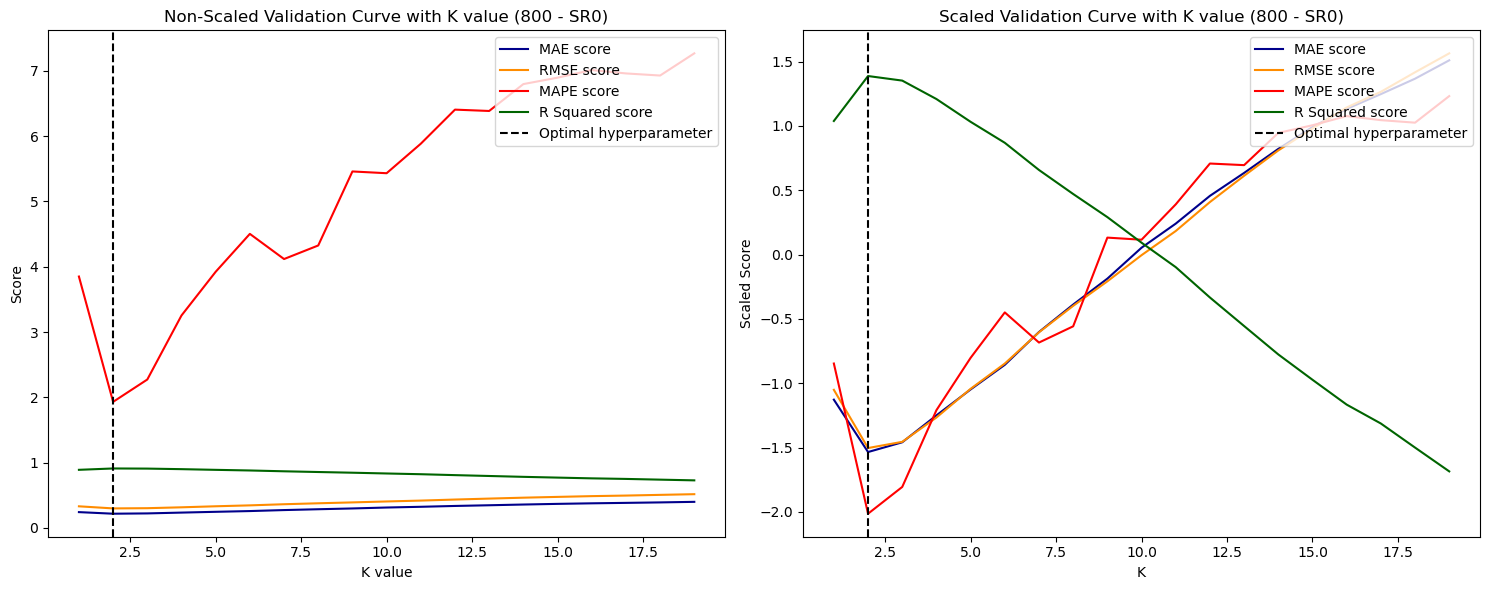

In [14]:
k = 2
df = pd.DataFrame(cv_score_list_800_k).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(neighbors_range, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(neighbors_range, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(neighbors_range, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(neighbors_range, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('K value')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with K value (800 - SR0)")

# Plot normalized data on the second subplot
ax[1].plot(neighbors_range, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('K')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with K value (800 - SR0)")

plt.tight_layout()
plt.show()

# 1000 points calibration

In [15]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR0/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR0_input_randomfield_cal1000.csv')
val_df = pd.read_csv(f'{file_path}val_SR0_input_randomfield_cal1000.csv')
test_df = pd.read_csv(f'{file_path}test_SR0_input_randomfield_cal1000.csv')

In [16]:
# Initialize an empty dictionary for storing scores
cv_score_list_1000_k = {}
neighbors_range = np.arange(1, 20)

start_time = time.time()

# For each hyperparameter value
for k in neighbors_range:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Instantiate and fit model with calibration data
    nn_model = KNeighborsRegressor(n_neighbors=k)
    nn_model.fit(combined_array_train,cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = nn_model.predict(combined_array_validation)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_1000_k[k] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_1000_k))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_1000_k.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in K = {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in K = {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Validation Score MAE,0.218437,0.183861,0.192118,0.198459,0.208034,0.221761,0.237298,0.250051,0.261208,0.275798,0.287533,0.298731,0.311188,0.321555,0.328974,0.338905,0.348812,0.355812,0.363172
Validation Score RMSE,0.296338,0.252049,0.259073,0.262584,0.273225,0.290781,0.311131,0.327172,0.341188,0.358297,0.372160,0.386922,0.400716,0.413706,0.423684,0.436786,0.449828,0.457990,0.467668
Validation Score MAPE,3.710119,1.823673,2.459446,2.166224,2.803545,3.471706,3.176516,3.872540,4.846991,5.356835,5.117670,5.217928,5.966203,6.217791,6.215905,6.707298,6.735930,6.822253,6.771097
Validation Score R Squared,0.909604,0.934605,0.930909,0.929024,0.923155,0.912963,0.900354,0.889814,0.880171,0.867852,0.857428,0.845893,0.834709,0.823820,0.815219,0.803614,0.791711,0.784083,0.774862


The smallest Validation Score MAE is 0.18386061487545435, found in K = 2.
The smallest Validation Score RMSE is 0.2520492389067274, found in K = 2.
The smallest Validation Score MAPE is 1.823672898568345, found in K = 2.
The largest Validation Score R Squared is 0.9346049677367059, found in K = 2.
Validation Computation Time: 0.13 seconds


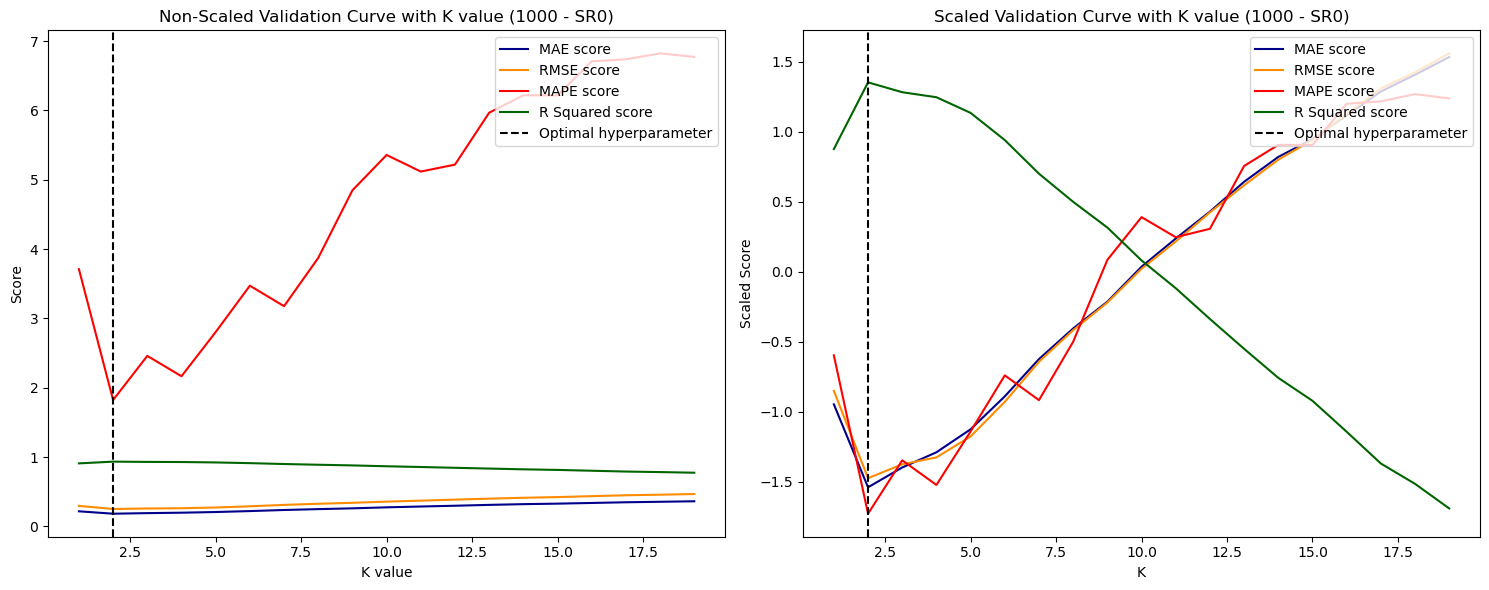

In [17]:
k = 2
df = pd.DataFrame(cv_score_list_1000_k).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(neighbors_range, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(neighbors_range, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(neighbors_range, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(neighbors_range, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('K value')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with K value (1000 - SR0)")

# Plot normalized data on the second subplot
ax[1].plot(neighbors_range, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('K')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with K value (1000 - SR0)")

plt.tight_layout()
plt.show()

# 1500 points calibration

In [18]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR0/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR0_input_randomfield_cal1500.csv')
val_df = pd.read_csv(f'{file_path}val_SR0_input_randomfield_cal1500.csv')
test_df = pd.read_csv(f'{file_path}test_SR0_input_randomfield_cal1500.csv')

In [19]:
# Initialize an empty dictionary for storing scores
cv_score_list_1500_k = {}
neighbors_range = np.arange(1, 20)

start_time = time.time()

# For each hyperparameter value
for k in neighbors_range:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Instantiate and fit model with calibration data
    nn_model = KNeighborsRegressor(n_neighbors=k)
    nn_model.fit(combined_array_train,cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = nn_model.predict(combined_array_validation)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_1500_k[k] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_1500_k))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_1500_k.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in K = {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in K = {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Validation Score MAE,0.187868,0.156624,0.158725,0.164795,0.170080,0.179809,0.191317,0.200089,0.210304,0.220383,0.228234,0.238441,0.248312,0.257123,0.264534,0.273472,0.281247,0.288751,0.297282
Validation Score RMSE,0.253399,0.220733,0.221831,0.224282,0.227886,0.238498,0.252007,0.263786,0.276407,0.288407,0.298915,0.310462,0.320985,0.331165,0.340738,0.351142,0.360239,0.369574,0.379309
Validation Score MAPE,3.131541,1.949902,1.980535,2.953522,2.726079,2.557263,2.861209,3.009435,3.697166,3.535338,3.934282,3.684327,4.131131,4.764942,4.906295,5.488937,5.384333,5.467905,5.599535
Validation Score R Squared,0.933902,0.949846,0.949345,0.948220,0.946542,0.941448,0.934627,0.928373,0.921355,0.914378,0.908025,0.900782,0.893942,0.887108,0.880487,0.873077,0.866416,0.859403,0.851899


The smallest Validation Score MAE is 0.15662350548184448, found in K = 2.
The smallest Validation Score RMSE is 0.22073327186292754, found in K = 2.
The smallest Validation Score MAPE is 1.9499024351414396, found in K = 2.
The largest Validation Score R Squared is 0.949845537655365, found in K = 2.
Validation Computation Time: 0.15 seconds


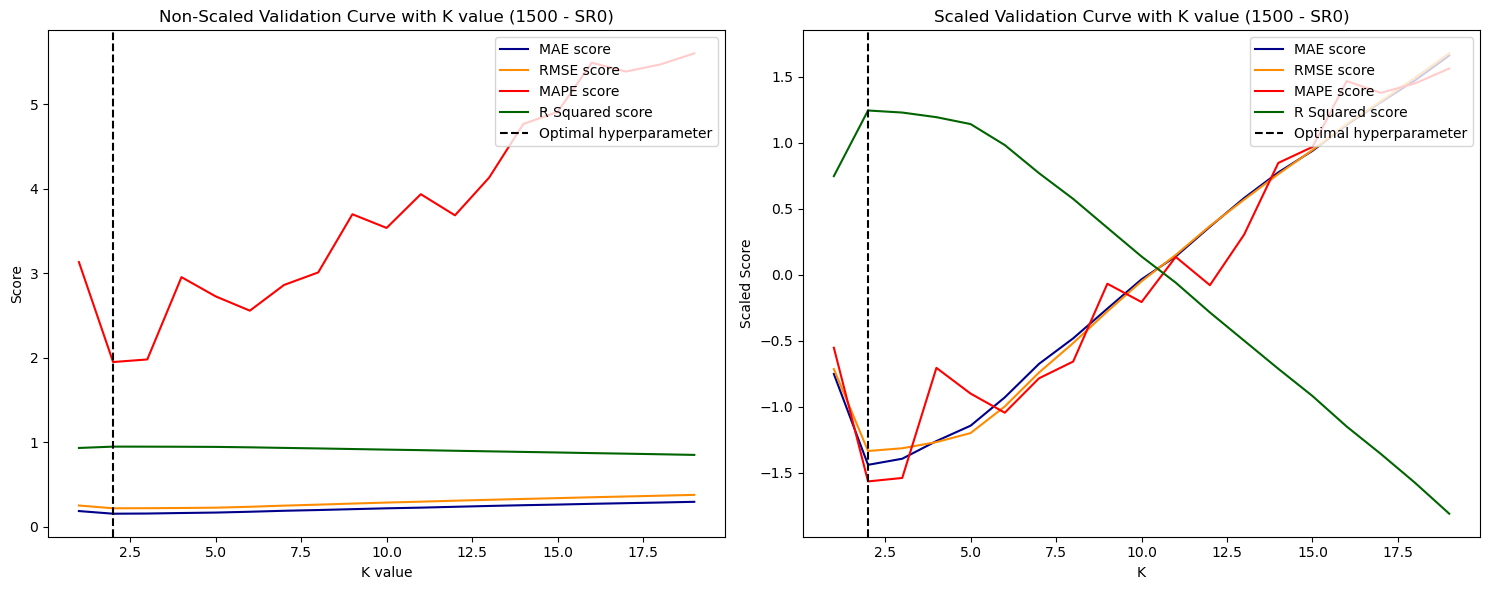

In [21]:
k = 2
df = pd.DataFrame(cv_score_list_1500_k).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(neighbors_range, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(neighbors_range, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(neighbors_range, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(neighbors_range, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('K value')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with K value (1500 - SR0)")

# Plot normalized data on the second subplot
ax[1].plot(neighbors_range, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('K')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with K value (1500 - SR0)")

plt.tight_layout()
plt.show()

# 2000 points calibration

In [22]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR0/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR0_input_randomfield_cal2000.csv')
val_df = pd.read_csv(f'{file_path}val_SR0_input_randomfield_cal2000.csv')
test_df = pd.read_csv(f'{file_path}test_SR0_input_randomfield_cal2000.csv')

In [23]:
# Initialize an empty dictionary for storing scores
cv_score_list_2000_k = {}
neighbors_range = np.arange(1, 20)

start_time = time.time()

# For each hyperparameter value
for k in neighbors_range:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Instantiate and fit model with calibration data
    nn_model = KNeighborsRegressor(n_neighbors=k)
    nn_model.fit(combined_array_train,cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = nn_model.predict(combined_array_validation)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_2000_k[k] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_2000_k))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_2000_k.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in K = {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in K = {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Validation Score MAE,0.165472,0.132334,0.133132,0.138564,0.143817,0.151502,0.159285,0.167202,0.174282,0.183768,0.190285,0.199816,0.209296,0.216221,0.224357,0.232046,0.239656,0.246398,0.252485
Validation Score RMSE,0.216698,0.180434,0.178691,0.186207,0.192665,0.199150,0.208817,0.215844,0.225456,0.238571,0.247207,0.257213,0.268685,0.278163,0.287823,0.296770,0.305508,0.313827,0.322316
Validation Score MAPE,3.236916,1.851202,1.620650,1.198644,2.123985,2.007329,2.024165,2.601761,3.215166,3.560765,3.044031,3.057535,2.991345,3.370741,3.787616,4.063639,4.385138,4.265391,4.551589
Validation Score R Squared,0.951663,0.966487,0.967132,0.964309,0.961790,0.959174,0.955114,0.952043,0.947676,0.941412,0.937093,0.931898,0.925687,0.920353,0.914724,0.909340,0.903923,0.898619,0.893061


The smallest Validation Score MAE is 0.13233403512211225, found in K = 2.
The smallest Validation Score RMSE is 0.17869053952012695, found in K = 3.
The smallest Validation Score MAPE is 1.1986436328164327, found in K = 4.
The largest Validation Score R Squared is 0.9671317109313577, found in K = 3.
Validation Computation Time: 0.15 seconds


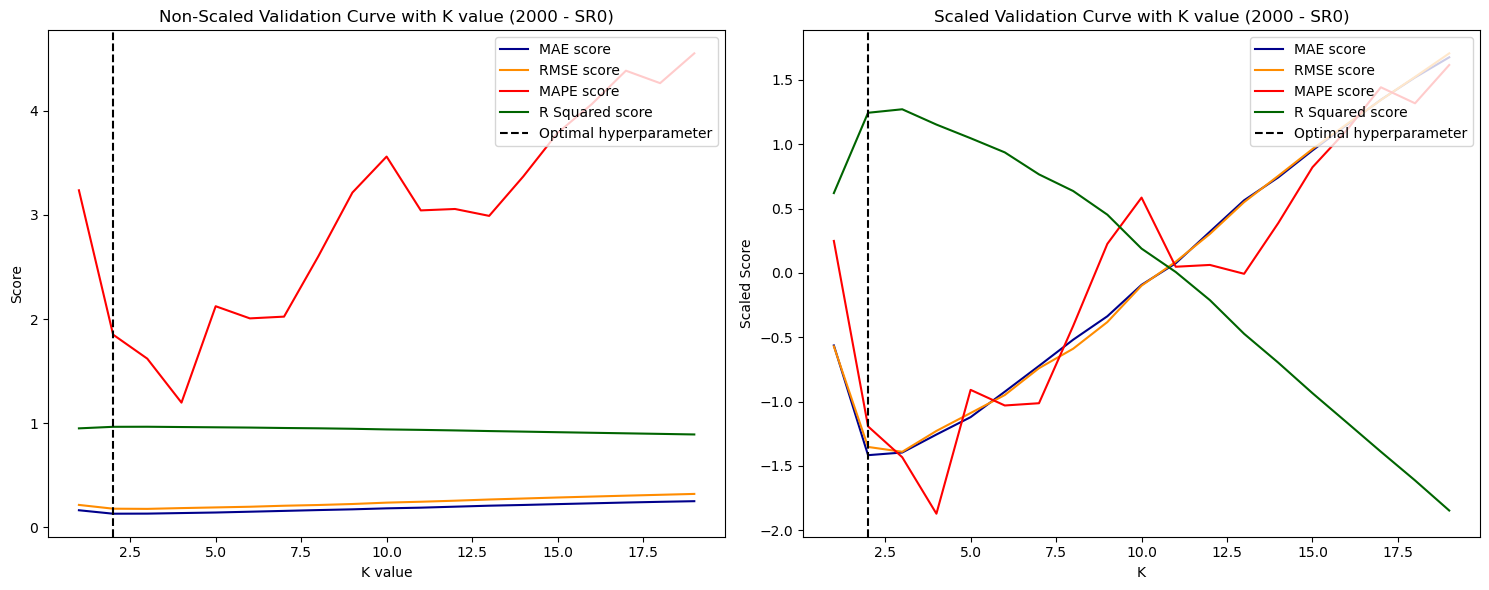

In [33]:
k = 2
df = pd.DataFrame(cv_score_list_2000_k).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(neighbors_range, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(neighbors_range, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(neighbors_range, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(neighbors_range, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('K value')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with K value (2000 - SR0)")

# Plot normalized data on the second subplot
ax[1].plot(neighbors_range, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('K')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with K value (2000 - SR0)")

plt.tight_layout()
plt.show()

## Validation score as calibration set size increases

In [26]:
def calculate_means(data_structures):
    all_means = {}
    for structure_id, data in enumerate(data_structures, 1):
        means = {key: sum(d[key] for d in data.values()) / len(data) for key in data[next(iter(data))]}
        all_means[f"Structure {structure_id}"] = means
    return all_means

# List of data structures
data_structures_k = [cv_score_list_200_k, cv_score_list_400_k, cv_score_list_600_k, cv_score_list_800_k,cv_score_list_1000_k,
                     cv_score_list_1500_k, cv_score_list_2000_k]

# Calculate means
all_means_k = calculate_means(data_structures_k)

In [27]:
new_keys = [200, 400, 600, 800, 1000, 1500, 2000]

# Function to replace keys
def replace_keys(structures, new_keys):
    # Make sure there are enough new keys for the structures
    if len(new_keys) < len(structures):
        raise ValueError("Not enough new keys for the number of structures")

    # New dictionary to store replaced key structures
    replaced_structures = {}

    # Use zip to iterate over both the items in structures and the new_keys simultaneously
    for new_key, (old_key, value) in zip(new_keys, structures.items()):
        replaced_structures[new_key] = value

    return replaced_structures

all_means_k = replace_keys(all_means_k, new_keys)

In [28]:
cal_size = [200, 400, 600, 800, 1000, 1500, 2000]
all_means_k_df = pd.DataFrame(all_means_k).T
all_means_k_df

,Validation Score MAE,Validation Score RMSE,Validation Score MAPE,Validation Score R Squared
200,0.515980,0.669763,6.993526,0.532982
400,0.407683,0.536830,6.398945,0.697106
600,0.350560,0.461411,6.365282,0.774954
800,0.307553,0.403953,5.243163,0.826827
1000,0.273774,0.356910,4.708404,0.863673
1500,0.221968,0.291040,3.777036,0.909957
2000,0.187364,0.243160,2.997769,0.936921


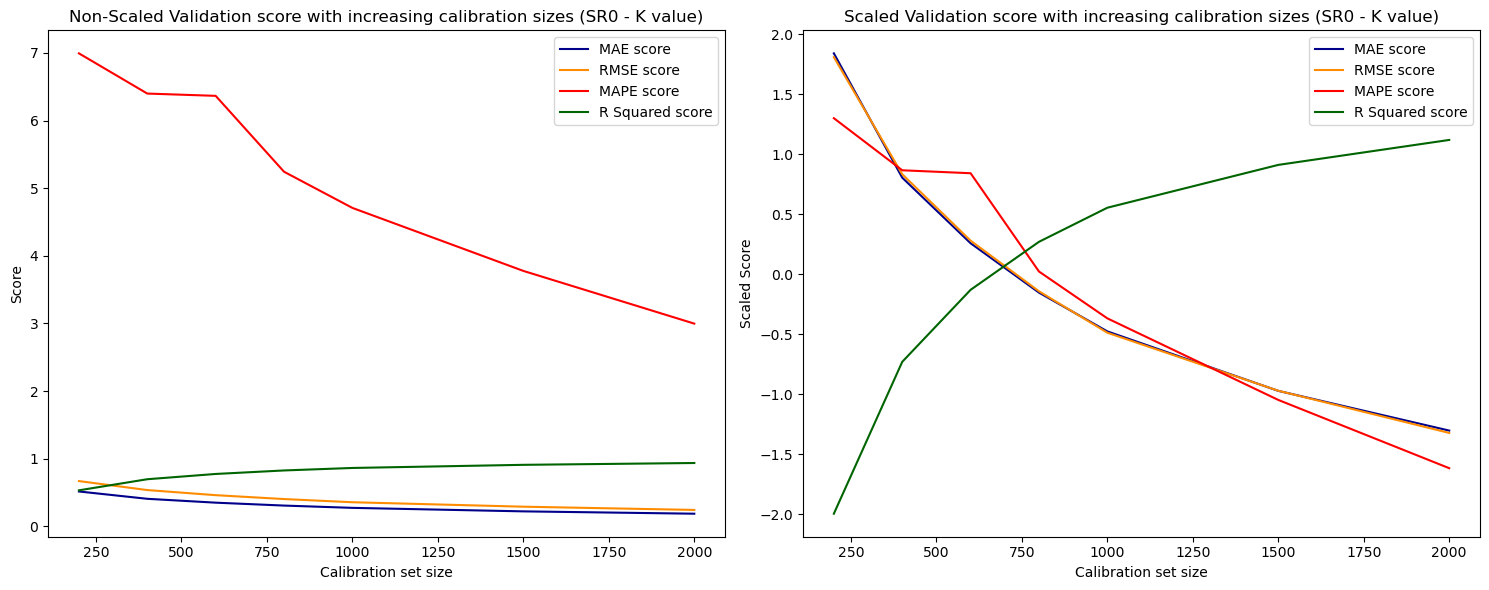

In [29]:
# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(all_means_k_df), columns=all_means_k_df.columns, index=all_means_k_df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(cal_size, all_means_k_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(cal_size, all_means_k_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(cal_size, all_means_k_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(cal_size, all_means_k_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].set_xlabel('Calibration set size')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation score with increasing calibration sizes (SR0 - K value)")

# Plot normalized data on the second subplot
ax[1].plot(cal_size, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(cal_size, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(cal_size, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(cal_size, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].set_xlabel('Calibration set size')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation score with increasing calibration sizes (SR0 - K value)")

plt.tight_layout()
plt.show()

## Testing model (Final Performance Metrics)

In [30]:
filenames = ['SR0_input_randomfield_cal200','SR0_input_randomfield_cal400', 'SR0_input_randomfield_cal600',
             'SR0_input_randomfield_cal800', 'SR0_input_randomfield_cal1000', 'SR0_input_randomfield_cal1500', 'SR0_input_randomfield_cal2000']
#cal_SR0_input_randomfield_cal2000.csv
combined_df = pd.DataFrame()
for file in filenames:
    cal_df = pd.read_csv(f'Synthetic Data/SR0/cal_{file}.csv')
    combined_df = pd.concat([cal_df, combined_df], ignore_index=True)

combined_df = pd.concat([val_df, combined_df], ignore_index=True)
combined_df = combined_df.drop_duplicates() #The calibration sets are subsets of one another, hence needed

combined_df #All caliration points and validation data points

,x,y,z
0,39,4,-0.520793
1,47,42,-0.373555
2,92,88,0.003110
3,24,43,-0.232004
4,37,92,-0.116758
...,...,...,...
3995,93,12,-3.031762
3996,56,25,0.305903
3997,22,8,-1.150329
3998,38,35,-0.539275


In [32]:
eval_combined_array_coordinates = np.array([list(pair) for pair in zip(combined_df['x'], combined_df['y'])])

start_time = time.time()

nn_model = KNeighborsRegressor(n_neighbors=2)
nn_model.fit(eval_combined_array_coordinates,combined_df['z'])

 # Predict at test locations
eval_combined_array_test = np.array([list(pair) for pair in zip(test_df['x'], test_df['y'])])
z_pred_test = nn_model.predict(eval_combined_array_test)
    
rmse = np.sqrt(mean_squared_error(test_df['z'], z_pred_test))
mae = mean_absolute_error(test_df['z'], z_pred_test)
mape = mean_absolute_percentage_error(test_df['z'], z_pred_test)
r2 = r2_score(test_df['z'], z_pred_test)

end_time = time.time()

print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape)
print("R Squared:", r2)
print(f"Testing Computation Time: {end_time - start_time:.2f} seconds")

MAE: 0.09525294253114558
RMSE: 0.1354337608598036
MAPE: 0.46178525467570064
R Squared: 0.9815013515864507
Testing Computation Time: 0.01 seconds


### Plotting Spatial Interpolation of entire area with Model

In [34]:
filenames = ['cal_SR0_input_randomfield_cal200', 'cal_SR0_input_randomfield_cal400', 'cal_SR0_input_randomfield_cal600', 'cal_SR0_input_randomfield_cal800', 'cal_SR0_input_randomfield_cal1000', 'cal_SR0_input_randomfield_cal1500', 'cal_SR0_input_randomfield_cal2000',
            'val_SR0_input_randomfield_cal2000', 'test_SR0_input_randomfield_cal2000']
#cal_SR0_input_randomfield_cal2000.csv
all_df = pd.DataFrame()
for file in filenames:
    df = pd.read_csv(f'Synthetic Data/SR0/{file}.csv')
    all_df = pd.concat([df, all_df], ignore_index=True)

all_df = all_df.drop_duplicates() #The calibration sets are subsets of one another, hence needed

all_df #All calbration, validation and test data points

,x,y,z
0,83,56,-0.838066
1,40,74,-0.436379
2,90,28,-0.031699
3,51,84,-0.388236
4,32,48,-1.099538
...,...,...,...
5995,93,12,-3.031762
5996,56,25,0.305903
5997,22,8,-1.150329
5998,38,35,-0.539275


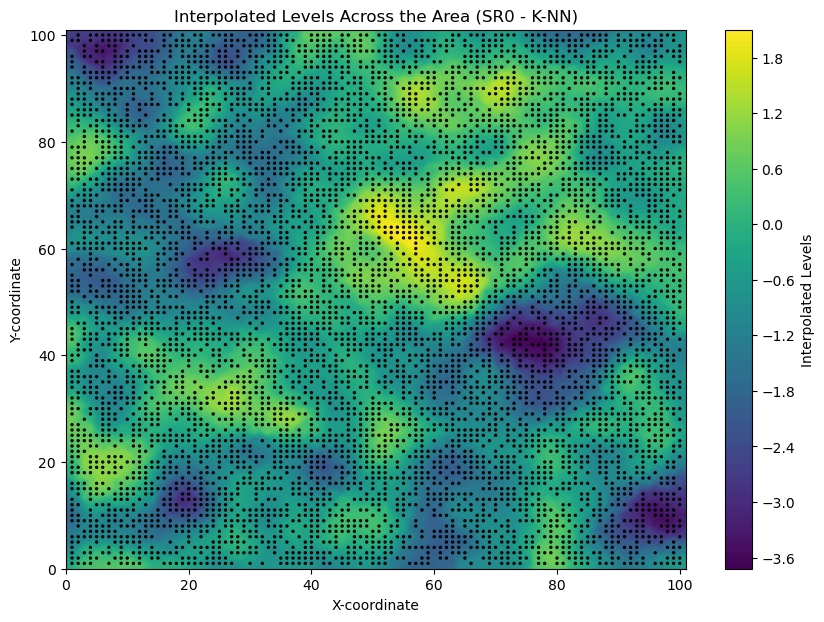

Spatial Interpolation Computation Time: 0.01 seconds


In [35]:
# Using full set: Convert columns to numpy arrays
observed_location_columns = ['x', 'y']
observed_values_column = 'z'
observed_locations = all_df[observed_location_columns].values
observed_values = all_df[observed_values_column].values

# Initialize IDW model
nn_model = KNeighborsRegressor(n_neighbors=2)
nn_model.fit(observed_locations,observed_values)

# Start timing spatial interpolation
start_time_interpolation = time.time()

x_min, x_max = observed_locations[:, 0].min() - 1, observed_locations[:, 0].max() + 1
y_min, y_max = observed_locations[:, 1].min() - 1, observed_locations[:, 1].max() + 1
x_range = np.linspace(x_min, x_max, 100)
y_range = np.linspace(y_min, y_max, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)
grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]

# Interpolate values
interpolated_values = nn_model.predict(grid_points)
z_grid = interpolated_values.reshape(x_grid.shape)

end_time_interpolation = time.time()  # End timing spatial interpolation

# Visualization
plt.figure(figsize=(10, 7))
plt.contourf(x_grid, y_grid, z_grid, cmap='viridis', levels=100)
plt.colorbar(label='Interpolated Levels')
plt.scatter(all_df['x'], all_df['y'], c=all_df['z'], cmap='viridis', edgecolor='k', label='Observed', s= 2.0)
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
#plt.legend()
plt.title('Interpolated Levels Across the Area (SR0 - K-NN)')
plt.show()

print(f"Spatial Interpolation Computation Time: {end_time_interpolation - start_time_interpolation:.2f} seconds")